##Importing all libraries which are required and Loading the model with appropriate layers 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
import struct
from keras.layers import Conv2D
from keras.models import Model
from numpy import expand_dims
from keras.models import load_model
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from skimage import io
from PIL import Image 
from keras.preprocessing import image

modelyolo = load_model('/content/drive/My Drive/YOLOModel.h5')

model =VGG16(input_shape=(224,224,3),include_top=False,
                                               weights='imagenet')


regularizer = tf.keras.regularizers.l2(0.01)
#Adding regularizer to overcome Overfitting of the model
for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)


for layer in model.layers[:11]:
  layer.trainable=False


Model = Sequential()
for layer in model.layers[:11]:
  layer.trainable=True
  Model.add(layer)
c=0  
for layer in model.layers[11:]:
  Model.add(layer)
  c+=1
  if c%4==0:
    Model.add(Dropout(0.3)) 

Model.add(GlobalAveragePooling2D())
Model.add(Dense(units=4098,activation="relu"))
Model.add(Dense(units=4098,activation="relu"))
Model.add(Dense(units=3, activation="softmax"))
Model.load_weights('/content/drive/My Drive/Traffic_Densen(VGG)(1)new.h5')

modelresnet =tf.keras.applications.ResNet101()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Functions required for yolo

In [ ]:
#functions required for V3
from keras.preprocessing import image
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier","toothbrush"] 
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()
 

## Function to check for ambulance.Here we are using yolo pretrained and ResNet model to get the predictions

In [ ]:
def checkambulance(photo_filename):#PASS IMAGE PATH AS ARGUMENT
  input_w, input_h = 416, 416
  from keras.preprocessing.image import image
  # load and prepare image
  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
  # make prediction
  yhat = modelyolo.predict(image)
  anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
  class_threshold = 0.6
  boxes = list()
  for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
  # suppress non-maximal boxes
  do_nms(boxes, 0.5)
  
  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
  im=io.imread(photo_filename)
  for i in range(len(v_boxes)):
    if(v_labels[i]=='truck' or v_labels[i]=='bus'):
      box=v_boxes[i]
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax      #EXTRACT CO-ORDINATES OF BOXES
      width, height = x2 - x1, y2 - y1
      if(height==0):
        height=1
      image1 =im[y1:y1+height,x1:x1+width]      #CROP BOX AND FEED TO ANOTHER MODEL
      image1 = cv2.resize(image1,(224,224), interpolation = cv2.INTER_AREA)
      img = np.expand_dims(image1, axis=0)
      result=modelresnet.predict(img)
      label = decode_predictions(result,top=15)
      for i in range(15):
        if(label[0][i][1]=='ambulance'):
          plt.imshow(image1)
          plt.show() 
          return True
  return False

## Code to allot the timing for four signals  
* Here lane class is defined to assign laneno,traffic_mode and  ambulance
* Traffic_manager class is created so as to check for ambulance  and manage the signals accordingly

*  Cycle function is defined so as to keep the cycle continuos without any interruption
  


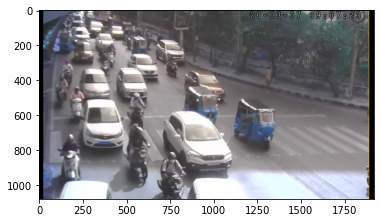

green for lane3  5 seconds


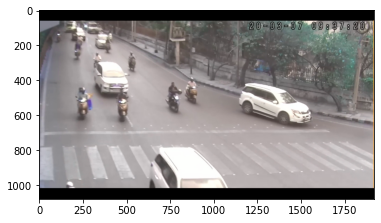

green for lane0  3 seconds


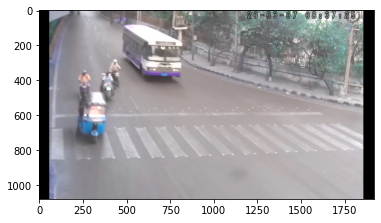

green for lane1  1 second


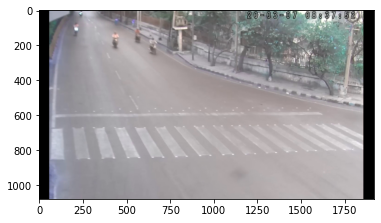

green for lane2  1 second


In [18]:
i1='/content/drive/My Drive/new_dataset/train/moderate/frame10704.jpg' #LANE0 Moderate Traffic
i2='/content/drive/My Drive/new_dataset/train/light/frame10656.jpg'    #LANE1 Light Traffic
i3='/content/drive/My Drive/new_dataset/train/light/frame11328.jpg'    #LANE2 Light Traffic
i4='/content/drive/My Drive/new_dataset/train/heavy/frame11136.jpg'    #LANE3 Heavy Traffic
z=[i1,i2,i3,i4]
import os
import time
from threading import Thread
from PIL import Image  
class Lane:
  def __init__(self,laneno,traffic_mode,ambulance):
    self.laneno=laneno
    self.ambulance=ambulance
    self.traffic_mode=traffic_mode
class Traffic_manager:
  @staticmethod
  def return_priority(tensor):
    for lane in tensor:
      if lane.ambulance:
        return lane
    priority=max(tensor,key=lambda l:l.traffic_mode)
    return priority

  @staticmethod
  def traffic_signal(lane,laneno,emergency=False):
    img=cv2.imread(z[laneno])
    plt.imshow(img)
    plt.show()
    print('green for lane'+str(laneno),end="  ")   
    if emergency:
      # print(lane,'emergency')
      time.sleep(4)
    else:
      if lane.traffic_mode==0:
        print("1 second")
        time.sleep(1)
      if lane.traffic_mode==1:
        print("3 seconds")
        time.sleep(3)
      if lane.traffic_mode==2:
        print("5 seconds")
        time.sleep(5)
  @staticmethod
  def cycle(tensor):
    lanes=[i.laneno for i in tensor]
    while tensor:
      prior=Traffic_manager.return_priority(tensor)
      arguments=[prior,prior.laneno,prior.ambulance==True]
      signalthread=Thread(target=Traffic_manager.traffic_signal,args=arguments)
      signalthread.start()
      if(prior.ambulance==False):
        tensor.remove(prior)
        lanes.remove(prior.laneno)
      
      tensor=Traffic_manager.predictions(z)
      tensor=[lane for lane in tensor if lane.laneno in lanes]
      signalthread.join()

  @staticmethod
  def predictions(images):
    p={}
    # images=get_images()
    for i in range(len(images)):
      img=load_img(images[i],target_size=(224,224,3))
      img=np.expand_dims(img,axis=0)
      a=Model.predict_classes(img)
      if(a==0):
        outcome=[2]
      if(a==1):
        outcome=[0]
      if(a==2):
        outcome=[1]
      p[i]=outcome
      p[i]+=[checkambulance(images[i])] #ex: p would be p={1:[high,false]},boolean represents presence of ambulance
      #p[i][0]=2-p[i][0]   ####  i did 2 minus outcome, because i considered 2 as heavy but the model considered 0 as heavy, thats it
    array=[] #this array consists of Lane objects
    for i in p:
      array.append(Lane(i,p[i][0],p[i][1]))
    return array

result=Traffic_manager.predictions(z)  #[[1,False],[2,False],[1,False],[0,True]]
# result=Traffic_manager.create_tensor(result,0,1,2,3)
Traffic_manager.cycle(result)